This notebook looks at the flux differences between DR4 and DR6 in the Bootes field.

data copied via:
*    mkdir -p bootes/dr4 bootes/dr6
*    rsync -Larv cori:cosmo/data/legacysurvey/dr4/tractor/217/tractor-217?p34?.fits bootes/dr4/
*    rsync -Larv cori:cosmo/data/legacysurvey/dr6/tractor/217/tractor-217?p34?.fits bootes/dr6/
*    rsync -Larv cori:cosmo/data/legacysurvey/dr6/coadd/217/2176p345/*-image-z.fits.fz bootes/dr6/
*    rsync -Larv cori:cosmo/data/legacysurvey/dr6/coadd/217/2176p345/*-invvar-z.fits.fz bootes/dr6/
*    rsync -Larv cori:cosmo/data/legacysurvey/dr4/coadd/217/2176p345/*-image-z.fits* bootes/dr4/
*    rsync -Larv cori:cosmo/data/legacysurvey/dr4/coadd/217/2176p345/*-invvar-z.fits* bootes/dr4/

In [1]:
%matplotlib inline
import pylab as plt
import numpy as np
from astrometry.util.fits import *
from astrometry.util.plotutils import *
from collections import Counter
from astrometry.libkd.spherematch import *
from astrometry.util.starutil import *
from glob import glob
import fitsio

Read all tractor catalogs

In [2]:
T4 = merge_tables([fits_table(fn) for fn in glob('bootes/dr4/tractor-*.fits')])

In [3]:
T6 = merge_tables([fits_table(fn) for fn in glob('bootes/dr6/tractor-*.fits')])

In [4]:
print(len(T4), len(T6))

50858 52009


Find matched/unmatched sources (not currently doing anything with these)

In [5]:
I,J,d = match_radec(T4.ra, T4.dec, T6.ra, T6.dec, 1./3600.)
# unmatched
U4 = np.ones(len(T4), bool)
U6 = np.ones(len(T6), bool)
U4[I] = False
U6[J] = False
U4 = T4[U4]
U6 = T6[U6]
print(len(U4), len(U6), 'unmatched')

2743 3925 unmatched


Find matched (nearest-neighbour within 0.5 arcsec) sources

In [6]:
I,J,d = match_radec(T4.ra, T4.dec, T6.ra, T6.dec, 0.5/3600., nearest=True)
len(I)
M4 = T4[I]
M6 = T6[J]

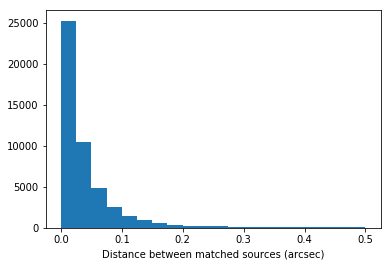

In [7]:
plt.hist(d*3600., 20);
plt.xlabel('Distance between matched sources (arcsec)');

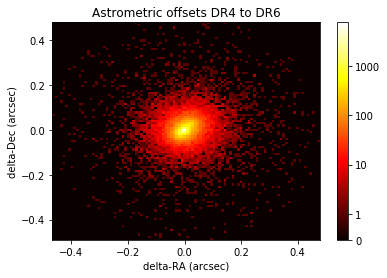

In [8]:
cosdec = np.cos(np.deg2rad(36.))
loghist(3600.*(M4.ra - M6.ra)*cosdec, 3600.*(M4.dec - M6.dec));
plt.title('Astrometric offsets DR4 to DR6')
plt.xlabel('delta-RA (arcsec)')
plt.ylabel('delta-Dec (arcsec)')

In [9]:
# Compute mags
with np.errstate(invalid='ignore', divide='ignore'):
    M4.g = 2.5*(np.log10(M4.flux_g)-9)
    M4.r = 2.5*(np.log10(M4.flux_r)-9)
    M4.z = 2.5*(np.log10(M4.flux_z)-9)
    M6.g = 2.5*(np.log10(M6.flux_g)-9)
    M6.r = 2.5*(np.log10(M6.flux_r)-9)
    M6.z = 2.5*(np.log10(M6.flux_z)-9)

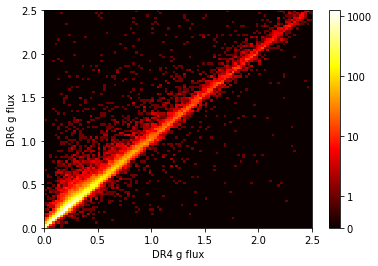

In [10]:
loghist(M4.flux_g, M6.flux_g, range=((0, 2.5),(0, 2.5)));
plt.xlabel('DR4 g flux')
plt.ylabel('DR6 g flux');

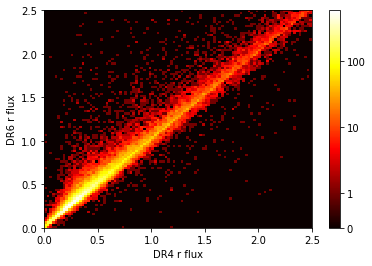

In [11]:
loghist(M4.flux_r, M6.flux_r, range=((0, 2.5),(0, 2.5)));
plt.xlabel('DR4 r flux')
plt.ylabel('DR6 r flux');

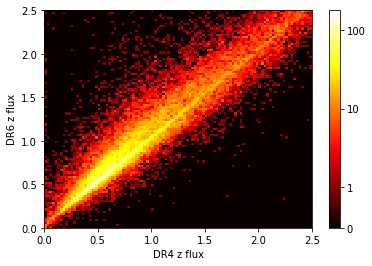

In [12]:
loghist(M4.flux_z, M6.flux_z, range=((0, 2.5),(0, 2.5)));
plt.xlabel('DR4 z flux')
plt.ylabel('DR6 z flux');

In [13]:
# Grab PSF sources
I = np.flatnonzero((M4.type == 'PSF ') * (M6.type == 'PSF '))
P4 = M4[I]
P6 = M6[I]

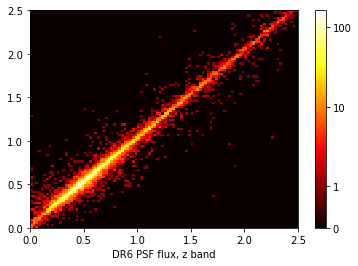

In [14]:
loghist(P4.flux_z, P6.flux_z, range=((0, 2.5),(0, 2.5)));
plt.xlabel('DR4 PSF flux, z band')
plt.xlabel('DR6 PSF flux, z band');

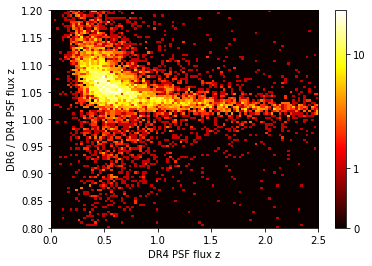

In [15]:
# Look at flux ratios
I = np.flatnonzero((P4.flux_z > 0) * (P6.flux_z > 0))
loghist(P4.flux_z[I], P6.flux_z[I] / P4.flux_z[I], range=((0, 2.5), (0.8, 1.2)));
plt.xlabel('DR4 PSF flux z')
plt.ylabel('DR6 / DR4 PSF flux z');

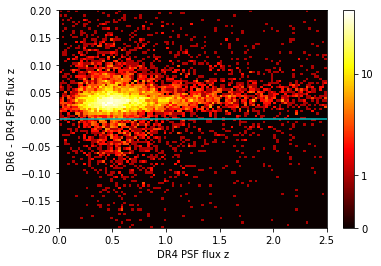

In [16]:
loghist(P4.flux_z, P6.flux_z - P4.flux_z, range=((0, 2.5), (-0.2, 0.2)));
plt.axhline(0, color='c')
plt.xlabel('DR4 PSF flux z')
plt.ylabel('DR6 - DR4 PSF flux z');
plt.savefig('fluxdiff.png')

Now look at the coadd images.

In [17]:
im4 = fitsio.read('bootes/dr4/legacysurvey-2176p345-image-z.fits')
im6 = fitsio.read('bootes/dr6/legacysurvey-2176p345-image-z.fits.fz')
iv4 = fitsio.read('bootes/dr4/legacysurvey-2176p345-invvar-z.fits')
iv6 = fitsio.read('bootes/dr6/legacysurvey-2176p345-invvar-z.fits.fz')

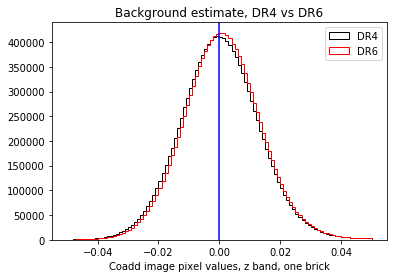

In [18]:
ha=dict(bins=100, histtype='step', range=(-0.05,0.05)) #, log=True)
plt.hist(im4[iv4>0].ravel(), color='k', label='DR4', **ha);
plt.hist(im6[iv6>0].ravel(), color='r', label='DR6', **ha);
plt.legend()
plt.axvline(0, color='b');
plt.xlabel('Coadd image pixel values, z band, one brick');
plt.title('Background estimate, DR4 vs DR6');
plt.savefig('sky1.png')

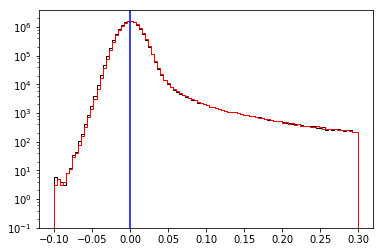

In [19]:
ha=dict(bins=100, histtype='step', range=(-0.1,0.3), log=True)
plt.hist(im4[iv4>0].ravel(), color='k', **ha);
plt.hist(im6[iv6>0].ravel(), color='r', **ha);
plt.axvline(0, color='b');

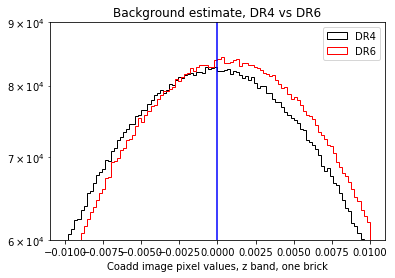

In [20]:
ha=dict(bins=100, histtype='step', range=(-0.01,0.01), log=True)
plt.hist(im4[iv4>0].ravel(), color='k', label='DR4', **ha);
plt.hist(im6[iv6>0].ravel(), color='r', label='DR6', **ha);
plt.axvline(0, color='b');
plt.legend();
plt.ylim(6e4, 9e4);
plt.xlabel('Coadd image pixel values, z band, one brick');
plt.title('Background estimate, DR4 vs DR6');
plt.savefig('sky2.png')

In [21]:
print(np.median(im4[iv4>0]))
print(np.median(im6[iv6>0]))

0.000134049
0.000949975


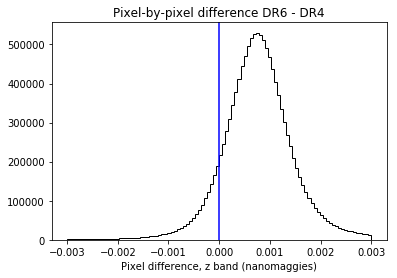

In [25]:
plt.hist((im6-im4)[(iv4>0)*(iv6>0)].ravel(), 100, histtype='step', color='k', range=(-0.003,0.003));
plt.title('Pixel-by-pixel difference DR6 - DR4')
plt.xlabel('Pixel difference, z band (nanomaggies)');
plt.axvline(0, color='b')
plt.savefig('sky3.png');

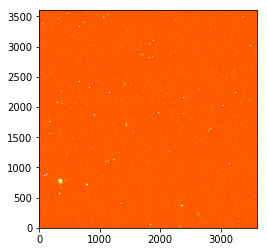

In [23]:
plt.imshow(im4, interpolation='nearest', origin='lower', vmin=-1, vmax=1);

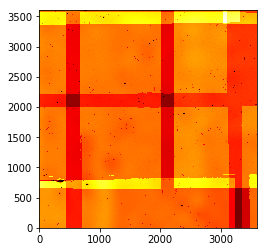

In [24]:
plt.imshow(iv4, interpolation='nearest', origin='lower');